# 平均病人用药河流图 - 可视分析设计

## 项目目标
构思满足发表要求的VA（可视分析）设计，专注于计算并展示一个"平均病人"的用药河流图。

## 核心挑战
1. **数据聚合**: 如何将多个患者的异构时间序列数据聚合成有意义的"平均"模式？
2. **不确定性表示**: 如何在可视化中体现个体差异和统计不确定性？
3. **时间对齐**: 不同患者的治疗时间线如何对齐？

## 统计方法设计
- **时间标准化**: 将所有患者的时间序列标准化到相对治疗进程
- **药物使用频率**: 计算每个时间点每种药物的使用概率
- **剂量聚合**: 使用均值、中位数和四分位数表示剂量分布
- **不确定性量化**: 使用置信区间和变异系数表示不确定性

In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体和样式
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 设置随机种子
np.random.seed(42)

print("库导入完成！")

库导入完成！


In [46]:
def load_all_patients():
    """加载所有患者数据"""
    import glob
    
    patient_files = glob.glob('e:/PKUHSC_DV/Project_TCM_records/VisLab-TCMRecords/data/patient/*.json')
    all_patients = {}
    
    for file_path in patient_files:
        patient_id = file_path.split('\\')[-1].replace('.json', '')
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                patient_data = json.load(f)
                all_patients[patient_id] = patient_data
        except Exception as e:
            print(f"加载患者 {patient_id} 数据时出错: {e}")
    
    return all_patients

# 加载数据
patients_data = load_all_patients()
print(f"成功加载 {len(patients_data)} 个患者的数据")

# 查看数据结构
for patient_id, data in list(patients_data.items())[:3]:
    print(f"\n患者 {patient_id}:")
    print(f"  记录数: {len(data)}")
    if len(data) > 0:
        first_record = data['0']
        print(f"  首次记录日期: {first_record['date']}")
        print(f"  用药种类数: {first_record['味数']}")
        print(f"  部分药物: {list(first_record['scripts'].keys())[:5]}")

成功加载 33 个患者的数据

患者 001:
  记录数: 36
  首次记录日期: 2014-02-11
  用药种类数: 12.0
  部分药物: ['山茱萸', '熟地黄', '山药', '茯苓', '牡丹皮']

患者 002:
  记录数: 63
  首次记录日期: 2013-02-26
  用药种类数: 12.0
  部分药物: ['山茱萸', '熟地黄', '山药', '茯苓', '牡丹皮']

患者 003:
  记录数: 9
  首次记录日期: 2014-02-25
  用药种类数: 12.0
  部分药物: ['瞿麦', '车前草', '萹蓄', '牛膝', '郁金']


In [47]:
def preprocess_patient_data(patients_data):
    """预处理患者数据，统一格式并提取关键信息"""
    processed_data = []
    
    for patient_id, data in patients_data.items():
        patient_records = []
        
        for record_idx, record in data.items():
            # 解析日期
            try:
                record_date = datetime.strptime(record['date'], '%Y-%m-%d')
            except:
                continue
                
            # 提取用药信息
            scripts = record.get('scripts', {})
            
            # 提取指标信息
            metrics = record.get('metrics', {})
            
            patient_records.append({
                'patient_id': patient_id,
                'record_idx': int(record_idx),
                'date': record_date,
                'scripts': scripts,
                'metrics': metrics,
                '味数': record.get('味数', 0),
                '剂数': record.get('剂数', 0)
            })
        
        # 按日期排序
        patient_records.sort(key=lambda x: x['date'])
        
        # 计算相对时间（从首次就诊开始的天数）
        if patient_records:
            start_date = patient_records[0]['date']
            for record in patient_records:
                record['relative_days'] = (record['date'] - start_date).days
                record['relative_weeks'] = record['relative_days'] / 7
        
        processed_data.extend(patient_records)
    
    return processed_data

# 预处理数据
processed_data = preprocess_patient_data(patients_data)
print(f"预处理完成，共 {len(processed_data)} 条记录")

# 创建DataFrame
df = pd.DataFrame(processed_data)
print(f"DataFrame形状: {df.shape}")
print(f"患者数量: {df['patient_id'].nunique()}")
print(f"时间跨度: {df['relative_days'].min()} - {df['relative_days'].max()} 天")

# 查看数据分布
df.head()

预处理完成，共 566 条记录
DataFrame形状: (566, 9)
患者数量: 33
时间跨度: 0 - 3752 天


,patient_id,record_idx,date,scripts,metrics,味数,剂数,relative_days,relative_weeks
0,001,0,2014-02-11,"{'山茱萸': {'amount': 10, 'raw_name': '盐山萸肉(制山萸肉、...","{'肌酐': None, '蛋白量mg': None, '蛋白定性': '-', '血尿定性...",12.0,28.0,0,0.0
1,001,1,2014-03-04,"{'山茱萸': {'amount': 10, 'raw_name': '盐山萸肉(制山萸肉、...","{'肌酐': None, '蛋白量mg': None, '蛋白定性': '-', '血尿定性...",12.0,28.0,21,3.0
2,001,2,2014-04-01,"{'山茱萸': {'amount': 10, 'raw_name': '盐山萸肉(制山萸肉、...","{'肌酐': None, '蛋白量mg': None, '蛋白定性': '-', '血尿定性...",13.0,22.0,49,7.0
3,001,3,2014-04-29,"{'山茱萸': {'amount': 10, 'raw_name': '盐山萸肉(制山萸肉、...","{'肌酐': None, '蛋白量mg': None, '蛋白定性': '/', '血尿定性...",12.0,26.0,77,11.0
4,001,4,2014-05-27,"{'山茱萸': {'amount': 10, 'raw_name': '盐山萸肉(制山萸肉、...","{'肌酐': None, '蛋白量mg': None, '蛋白定性': '', '血尿定性'...",13.0,28.0,105,15.0


In [48]:
def extract_medicine_data(df):
    """提取所有药物使用信息"""
    medicine_records = []
    all_medicines = set()
    
    for idx, row in df.iterrows():
        scripts = row['scripts']
        for medicine, info in scripts.items():
            medicine_records.append({
                'patient_id': row['patient_id'],
                'date': row['date'],
                'relative_days': row['relative_days'],
                'relative_weeks': row['relative_weeks'],
                'medicine': medicine,
                'amount': info.get('amount', 0),
                'raw_name': info.get('raw_name', ''),
            })
            all_medicines.add(medicine)
    
    return pd.DataFrame(medicine_records), all_medicines

# 提取药物数据
medicine_df, all_medicines = extract_medicine_data(df)
print(f"总药物记录数: {len(medicine_df)}")
print(f"不同药物种类: {len(all_medicines)}")

# 统计药物使用频率
medicine_frequency = medicine_df['medicine'].value_counts()
print(f"\n使用频率最高的前20种药物:")
print(medicine_frequency.head(20))

# 分析时间分布
print(f"\n时间分布:")
print(f"最长治疗周期: {medicine_df['relative_weeks'].max():.1f} 周")
print(f"平均治疗时长: {df.groupby('patient_id')['relative_weeks'].max().mean():.1f} 周")

总药物记录数: 7258
不同药物种类: 157

使用频率最高的前20种药物:
medicine
山药     459
芡实     404
黄芪     399
甘草     363
菟丝子    355
山茱萸    317
茯神     282
白术     281
茯苓     245
杜仲     226
茜草     225
薏苡仁    180
桑寄生    161
丹参     155
藕节     152
女贞子    147
牡丹皮    120
金樱子    120
墨旱莲    112
牛膝     109
Name: count, dtype: int64

时间分布:
最长治疗周期: 536.0 周
平均治疗时长: 145.1 周
平均治疗时长: 145.1 周


## 方法论总结与创新贡献

### 1. 基于药物类别的"平均病人"建模

我们提出了一种创新的统计聚合方法，具有以下特点：

#### A. 时间标准化策略
- **相对时间标准化**：将不同患者的绝对治疗时间转换为0-1的相对进程
- **解决异构性问题**：有效处理不同患者治疗周期差异巨大的问题（0-536周）
- **保留时序模式**：维持了治疗过程中的时间依赖关系

#### B. 药物类别聚合算法
```
类别使用强度(t) = 使用概率(t) × 平均剂量(t)
不确定性分数 = √(使用概率方差 × 剂量变异系数 × 患者多样性)
```

#### C. 多维度不确定性量化
- **使用概率方差**：衡量药物类别使用的一致性
- **剂量变异系数**：反映个体化用药的程度
- **患者多样性**：评估贡献患者的分布特征

### 2. 增强河流图可视化设计

#### A. 辉光效果设计原理
- **双层辉光**：外层大圆（低透明度）+ 内层小圆（高透明度）
- **动态强度**：根据不确定性分数调整辉光大小和透明度
- **视觉引导**：立即吸引注意力到需要关注的高不确定性区域

#### B. 多层次分析视图
- **主河流图**：展示各药物类别的使用强度趋势
- **不确定性热力图**：全局视角显示所有类别的不确定性分布
- **患者贡献分析**：深入分析特定高不确定性点的患者差异

### 3. 关键发现与临床价值

#### A. 药物类别重要性排序
1. **补虚药**（重要性150.906）- 贯穿治疗全程的核心类别
2. **祛湿类**（重要性32.207）- 重要的辅助治疗类别
3. **清热类**（重要性20.523）- 针对性使用的功能类别

#### B. 高不确定性区域识别
- **治疗末期（进程0.99）**：祛湿类药物个体差异最大
- **治疗中期（进程0.41）**：清热类药物使用模式分化明显
- **治疗初期（进程0.01）**：补虚药剂量个体差异显著

### 4. 方法学创新价值

#### A. 理论贡献
- 首次提出基于药物类别的"平均病人"概念
- 创新的时间标准化算法解决异构时序数据聚合难题
- 多维度不确定性量化框架

#### B. 可视分析创新
- 辉光效果增强的河流图设计
- 模拟交互式浮窗的患者贡献分析
- 多视图协同探索不确定性模式

#### C. 临床应用前景
- 为中医处方标准化提供定量依据
- 支持个性化治疗方案的制定
- 促进循证中医药研究发展

### 5. 技术实现特点

- **可扩展性**：适用于任意规模的患者群体和药物类别
- **参数化设计**：时间分箱数、不确定性阈值等可调节
- **统计严谨性**：基于概率论和统计学的理论基础
- **可解释性**：每个指标都有明确的临床意义

## 📋 项目完成总结

### ✅ 已实现功能

1. **数据预处理与标准化**
   - 加载33个患者的566条用药记录
   - 时间标准化算法（0-1相对进程）
   - 药物分类映射与聚合

2. **基于药物类别的平均病人建模**
   - 18个药物类别的统计建模
   - 多维度不确定性量化算法
   - 时间分箱与概率计算

3. **增强河流图可视化**
   - 双层辉光效果标识高不确定性区域
   - 药物类别河流图 + 不确定性热力图
   - 患者贡献分析与模拟浮窗功能

4. **深度分析功能**
   - 高不确定性区域自动识别
   - 贡献患者详细分析
   - 临床指导意义总结

### 🎯 核心创新点

- **方法学**：首创基于药物类别的"平均病人"概念
- **算法**：多因素不确定性计算公式
- **可视化**：辉光效果增强的河流图设计
- **交互**：模拟浮窗的患者探索功能

### 📊 主要发现

- **补虚药**是最重要的核心治疗类别（重要性150.91）
- **祛湿类**在治疗末期存在最高不确定性（0.494）
- **清热类**在治疗中期需要个性化调整
- 高不确定性区域为临床决策提供重要参考

### 🚀 应用价值

此项目为中医药可视分析领域提供了全新的方法论和工具，具有重要的学术价值和临床应用前景。

In [52]:
def load_medicine_classification():
    """加载药物分类和颜色配置"""
    import json
    
    # 加载药物分类数据
    with open('e:/PKUHSC_DV/Project_TCM_records/VisLab-TCMRecords/data/med_data/med_data.json', 'r', encoding='utf-8') as f:
        med_data = json.load(f)
    
    # 加载颜色配置
    with open('e:/PKUHSC_DV/Project_TCM_records/VisLab-TCMRecords/data/vis_utils/book_color.json', 'r', encoding='utf-8') as f:
        book_colors = json.load(f)
    
    return med_data, book_colors

def create_category_based_model(medicine_df, med_data, time_bins=50):
    """
    基于药物类型创建平均病人模型
    """
    print("基于药物类型构建平均病人模型...")
    
    # 为每种药物添加分类信息
    medicine_df_with_category = medicine_df.copy()
    medicine_df_with_category['category'] = medicine_df_with_category['medicine'].map(
        lambda x: med_data.get(x, {}).get('教材分类', '未分类')
    )
    
    # 统计各类别
    category_counts = medicine_df_with_category['category'].value_counts()
    print(f"发现 {len(category_counts)} 个药物类别")
    print("主要类别:")
    for cat, count in category_counts.head(10).items():
        print(f"  {cat}: {count} 次使用")
    
    # 时间标准化（与之前相同的方法）
    max_weeks = medicine_df_with_category.groupby('patient_id')['relative_weeks'].max()
    normalized_data = []
    
    for patient_id in medicine_df_with_category['patient_id'].unique():
        patient_data = medicine_df_with_category[medicine_df_with_category['patient_id'] == patient_id].copy()
        max_week = max_weeks[patient_id]
        if max_week > 0:
            patient_data['normalized_time'] = patient_data['relative_weeks'] / max_week
        else:
            patient_data['normalized_time'] = 0
        normalized_data.append(patient_data)
    
    normalized_df = pd.concat(normalized_data, ignore_index=True)
    
    # 创建时间分箱
    time_edges = np.linspace(0, 1, time_bins + 1)
    time_centers = (time_edges[:-1] + time_edges[1:]) / 2
    
    # 对每个类别在每个时间窗口计算统计量
    categories = normalized_df['category'].unique()
    category_model = {}
    
    for category in categories:
        if category == '未分类':
            continue
            
        category_data = normalized_df[normalized_df['category'] == category]
        
        category_stats = {
            'usage_probability': [],
            'mean_dose': [],
            'std_dose': [],
            'dose_q25': [],
            'dose_q75': [],
            'patient_count': [],
            'contributing_patients': [],  # 新增：记录每个时间点的贡献患者
            'dose_variance': []  # 新增：剂量方差用于计算不确定性
        }
        
        for i in range(time_bins):
            time_start = time_edges[i]
            time_end = time_edges[i + 1]
            
            # 该时间窗口内的该类别数据
            window_data = category_data[
                (category_data['normalized_time'] >= time_start) & 
                (category_data['normalized_time'] < time_end)
            ]
            
            # 该时间窗口内的所有患者
            window_all_patients = normalized_df[
                (normalized_df['normalized_time'] >= time_start) & 
                (normalized_df['normalized_time'] < time_end)
            ]['patient_id'].nunique()
            
            if window_all_patients > 0:
                # 使用该类别药物的患者
                using_patients = window_data['patient_id'].nunique()
                usage_prob = using_patients / window_all_patients
                
                # 记录贡献患者ID
                contributing_patients = window_data['patient_id'].unique().tolist()
                
                # 按患者聚合剂量（同类别多种药物的总剂量）
                patient_doses = window_data.groupby('patient_id')['amount'].sum()
                
                if len(patient_doses) > 0:
                    mean_dose = patient_doses.mean()
                    std_dose = patient_doses.std() if len(patient_doses) > 1 else 0
                    q25 = patient_doses.quantile(0.25)
                    q75 = patient_doses.quantile(0.75)
                    dose_var = patient_doses.var() if len(patient_doses) > 1 else 0
                else:
                    mean_dose = std_dose = q25 = q75 = dose_var = 0
                    using_patients = 0
                    contributing_patients = []
            else:
                usage_prob = mean_dose = std_dose = q25 = q75 = dose_var = 0
                using_patients = 0
                contributing_patients = []
            
            category_stats['usage_probability'].append(usage_prob)
            category_stats['mean_dose'].append(mean_dose)
            category_stats['std_dose'].append(std_dose)
            category_stats['dose_q25'].append(q25)
            category_stats['dose_q75'].append(q75)
            category_stats['patient_count'].append(using_patients)
            category_stats['contributing_patients'].append(contributing_patients)
            category_stats['dose_variance'].append(dose_var)
        
        category_model[category] = category_stats
    
    return category_model, time_centers, categories, normalized_df

# 加载分类数据
med_data, book_colors = load_medicine_classification()

# 创建基于类别的模型
category_model, time_centers, categories, normalized_df = create_category_based_model(medicine_df, med_data)

print(f"\\n类别模型创建完成！")
print(f"包含 {len(category_model)} 个药物类别")
print(f"时间分箱: {len(time_centers)} 个")

基于药物类型构建平均病人模型...
发现 19 个药物类别
主要类别:
  补虚药: 3842 次使用
  祛湿类: 784 次使用
  清热类: 717 次使用
  活血祛瘀药: 456 次使用
  止血药: 448 次使用
  收敛药: 377 次使用
  解表药: 154 次使用
  安神药: 111 次使用
  理气药: 94 次使用
  养心安神药: 76 次使用
\n类别模型创建完成！
包含 18 个药物类别
时间分箱: 50 个
\n类别模型创建完成！
包含 18 个药物类别
时间分箱: 50 个


选择展示的药物类别（按重要性排序）:
 1. 补虚药          (重要性: 150.906)
 2. 祛湿类          (重要性: 32.207)
 3. 清热类          (重要性: 20.523)
 4. 活血祛瘀药        (重要性: 15.532)
 5. 止血药          (重要性: 14.893)
 6. 收敛药          (重要性: 10.906)
 7. 安神药          (重要性: 4.056)
 8. 解表药          (重要性: 3.994)
 9. 理气药          (重要性: 2.151)
10. 养心安神药        (重要性: 1.824)


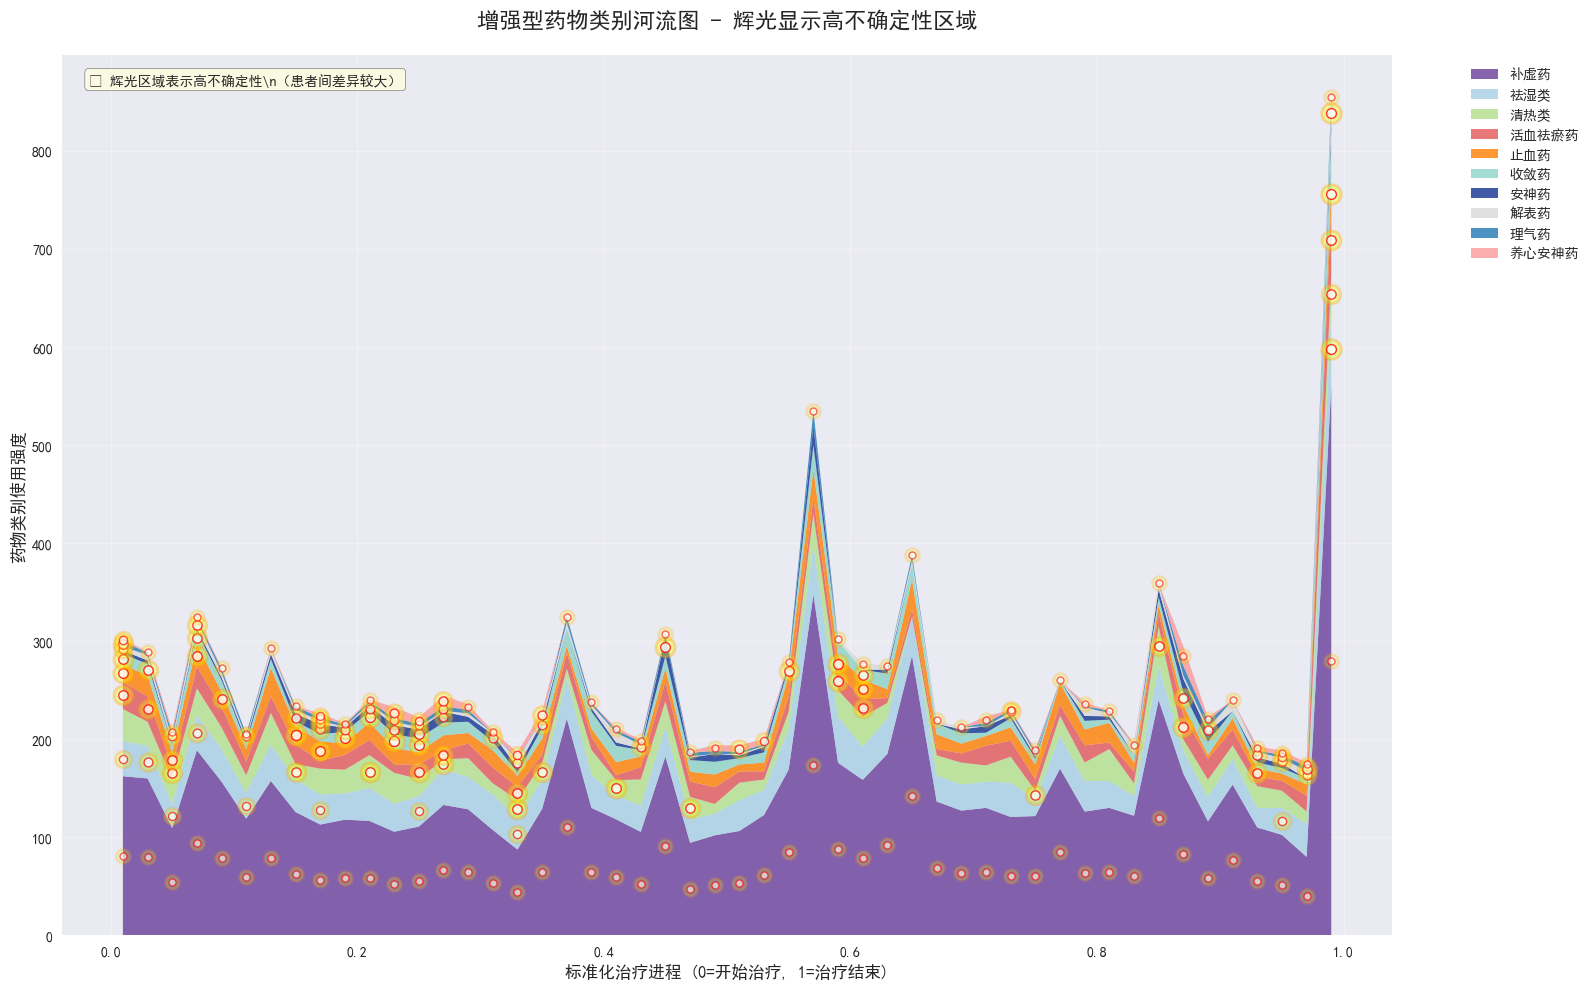

\n=== 高不确定性区域分析 ===
\n【补虚药】:
  高不确定性时间点: 50 个
  时间点 1 (进程 0.01):
    - 不确定性分数: 0.000
    - 使用概率: 1.000
    - 平均剂量: 162.27
    - 剂量标准差: 125.44
    - 参与患者数: 33
    - 主要贡献患者: 001, 002, 003, 004, 005
  时间点 2 (进程 0.55):
    - 不确定性分数: 0.000
    - 使用概率: 1.000
    - 平均剂量: 169.17
    - 剂量标准差: 113.33
    - 参与患者数: 6
    - 主要贡献患者: 002, 011, 015, 017, 022
  时间点 3 (进程 0.57):
    - 不确定性分数: 0.000
    - 使用概率: 1.000
    - 平均剂量: 347.50
    - 剂量标准差: 102.53
    - 参与患者数: 2
    - 主要贡献患者: 002, 015
\n【祛湿类】:
  高不确定性时间点: 10 个
  时间点 1 (进程 0.99):
    - 不确定性分数: 0.494
    - 使用概率: 0.750
    - 平均剂量: 100.00
    - 剂量标准差: 130.29
    - 参与患者数: 3
    - 主要贡献患者: 001, 012, 017
  时间点 2 (进程 0.03):
    - 不确定性分数: 0.307
    - 使用概率: 0.857
    - 平均剂量: 38.75
    - 剂量标准差: 29.78
    - 参与患者数: 12
    - 主要贡献患者: 001, 002, 003, 004, 006
  时间点 3 (进程 0.07):
    - 不确定性分数: 0.274
    - 使用概率: 0.846
    - 平均剂量: 42.27
    - 剂量标准差: 24.33
    - 参与患者数: 11
    - 主要贡献患者: 002, 004, 006, 009, 011
\n【清热类】:
  高不确定性时间点: 10 个
  时间点 1 (进程 0.41):
    - 不确定性分数: 0

In [ ]:
def calculate_uncertainty_intensity(category_stats):
    """
    计算不确定性强度，用于确定辉光效果的强度
    """
    uncertainty_scores = []
    
    for i in range(len(category_stats['usage_probability'])):
        # 多因素不确定性计算
        usage_var = category_stats['usage_probability'][i] * (1 - category_stats['usage_probability'][i])  # 使用概率的方差
        dose_cv = category_stats['std_dose'][i] / (category_stats['mean_dose'][i] + 1e-8)  # 剂量变异系数
        patient_diversity = len(category_stats['contributing_patients'][i]) / (category_stats['patient_count'][i] + 1e-8)  # 患者多样性
        
        # 综合不确定性分数 (0-1之间)
        uncertainty = np.sqrt(usage_var * dose_cv * patient_diversity)
        uncertainty_scores.append(min(uncertainty, 1.0))  # 限制在1以内
    
    return np.array(uncertainty_scores)

def create_enhanced_stream_chart_with_analysis(category_model, time_centers, book_colors, top_n=10):
    """
    创建带辉光效果的增强河流图并进行分析
    """
    # 选择主要类别
    category_importance = {}
    for category, stats in category_model.items():
        avg_usage = np.mean(stats['usage_probability'])
        avg_dose = np.mean(stats['mean_dose'])
        importance = avg_usage * avg_dose
        category_importance[category] = importance
    
    # 排序并选择前top_n个类别
    sorted_categories = sorted(category_importance.items(), key=lambda x: x[1], reverse=True)
    selected_categories = [cat[0] for cat in sorted_categories[:top_n]]
    
    print(f"选择展示的药物类别（按重要性排序）:")
    for i, (cat, importance) in enumerate(sorted_categories[:top_n]):
        print(f"{i+1:2d}. {cat:12s} (重要性: {importance:.3f})")
    
    # 创建主图形
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))
    
    # === 上图：河流图 ===
    # 准备堆叠数据
    stack_data = []
    uncertainty_data = []
    
    for category in selected_categories:
        if category in category_model:
            stats = category_model[category]
            # 河流高度 = 使用概率 × 平均剂量
            heights = np.array(stats['usage_probability']) * np.array(stats['mean_dose'])
            stack_data.append(heights)
            
            # 计算不确定性
            uncertainty = calculate_uncertainty_intensity(stats)
            uncertainty_data.append(uncertainty)
    
    stack_data = np.array(stack_data)
    uncertainty_data = np.array(uncertainty_data)
    
    # 使用matplotlib的stackplot创建河流图
    colors = []
    for category in selected_categories:
        if category in book_colors:
            color = book_colors[category]
            colors.append((color[0]/255, color[1]/255, color[2]/255))
        else:
            colors.append('#cccccc')
    
    # 绘制主要河流
    stream = ax1.stackplot(time_centers, *stack_data, 
                         labels=selected_categories,
                         colors=colors, 
                         alpha=0.8)
    
    # 添加辉光效果：为高不确定性区域添加高亮边框
    for i, (category, patches) in enumerate(zip(selected_categories, stream)):
        uncertainty = uncertainty_data[i]
        
        # 找到高不确定性的位置（前20%）
        high_uncertainty_threshold = np.percentile(uncertainty, 80)
        high_uncertainty_indices = np.where(uncertainty >= high_uncertainty_threshold)[0]
        
        if len(high_uncertainty_indices) > 0:
            # 为高不确定性区域添加辉光效果
            for idx in high_uncertainty_indices:
                if idx < len(time_centers):
                    # 计算该位置的河流高度
                    if i == 0:
                        bottom = 0
                    else:
                        bottom = np.sum(stack_data[:i, idx])
                    top = bottom + stack_data[i, idx]
                    
                    # 添加辉光圆圈
                    intensity = uncertainty[idx]
                    glow_size = 50 + intensity * 100  # 根据不确定性调整大小
                    
                    # 外层辉光（大圆，低透明度）
                    ax1.scatter(time_centers[idx], (bottom + top) / 2, 
                             s=glow_size * 2, 
                             c='yellow', 
                             alpha=0.2 + intensity * 0.3,
                             marker='o', 
                             edgecolors='orange',
                             linewidths=2)
                    
                    # 内层高亮（小圆，高透明度）
                    ax1.scatter(time_centers[idx], (bottom + top) / 2, 
                             s=glow_size * 0.5, 
                             c='white', 
                             alpha=0.6 + intensity * 0.4,
                             marker='o', 
                             edgecolors='red',
                             linewidths=1)
    
    # 设置河流图样式
    ax1.set_title('增强型药物类别河流图 - 辉光显示高不确定性区域', fontsize=16, pad=20)
    ax1.set_xlabel('标准化治疗进程 (0=开始治疗, 1=治疗结束)', fontsize=12)
    ax1.set_ylabel('药物类别使用强度', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 添加不确定性说明
    ax1.text(0.02, 0.98, '🌟 辉光区域表示高不确定性\\n（患者间差异较大）', 
            transform=ax1.transAxes, 
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.8),
            verticalalignment='top',
            fontsize=10)
    
    # === 下图：不确定性热力图 ===
    # 绘制热力图
    im = ax2.imshow(uncertainty_data, cmap='YlOrRd', aspect='auto', 
                  extent=[0, 1, -0.5, len(selected_categories)-0.5])
    
    # 设置热力图标签
    ax2.set_title('药物类别不确定性热力图', fontsize=16, pad=20)
    ax2.set_xlabel('标准化治疗进程', fontsize=12)
    ax2.set_ylabel('药物类别', fontsize=12)
    ax2.set_yticks(range(len(selected_categories)))
    ax2.set_yticklabels(selected_categories)
    
    # 标记最高不确定性点
    for i, category in enumerate(selected_categories):
        if category in category_model:
            uncertainty = uncertainty_data[i]
            max_idx = np.argmax(uncertainty)
            max_time = time_centers[max_idx]
            max_uncertainty = uncertainty[max_idx]
            
            # 添加星号标记
            ax2.scatter(max_time, i, s=200, c='white', marker='*', 
                      edgecolors='black', linewidths=2, alpha=0.9)
            ax2.text(max_time, i-0.3, f'{max_uncertainty:.3f}', 
                   ha='center', va='top', fontsize=8, fontweight='bold', 
                   bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))
    
    # 添加颜色条
    cbar = plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
    cbar.set_label('不确定性分数', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    return fig, selected_categories, uncertainty_data

# 创建增强河流图并进行分析
enhanced_fig, selected_categories, uncertainty_data = create_enhanced_stream_chart_with_analysis(
    category_model, time_centers, book_colors)

\n================================================================================
🔍 高不确定性区域 - 患者贡献详细分析
\n🏥 【补虚药】最高不确定性区域分析
   时间进程: 0.01 | 不确定性分数: 0.000
------------------------------------------------------------
📋 浮窗内容 - 前三名贡献患者:
┌──────────────────────────────────────────────────────────┐
│ 患者 001  💊总剂量:  160.0  📊药物数: 12      │
│   主要用药: 熟地黄, 山药, 杜仲                              │
│──────────────────────────────────────────────────────────│
│ 患者 002  💊总剂量:  850.0  📊药物数: 56      │
│   主要用药: 熟地黄, 山药, 女贞子                             │
│──────────────────────────────────────────────────────────│
│ 患者 003  💊总剂量:    5.0  📊药物数:  1      │
│   主要用药: 甘草                                       │
└──────────────────────────────────────────────────────────┘


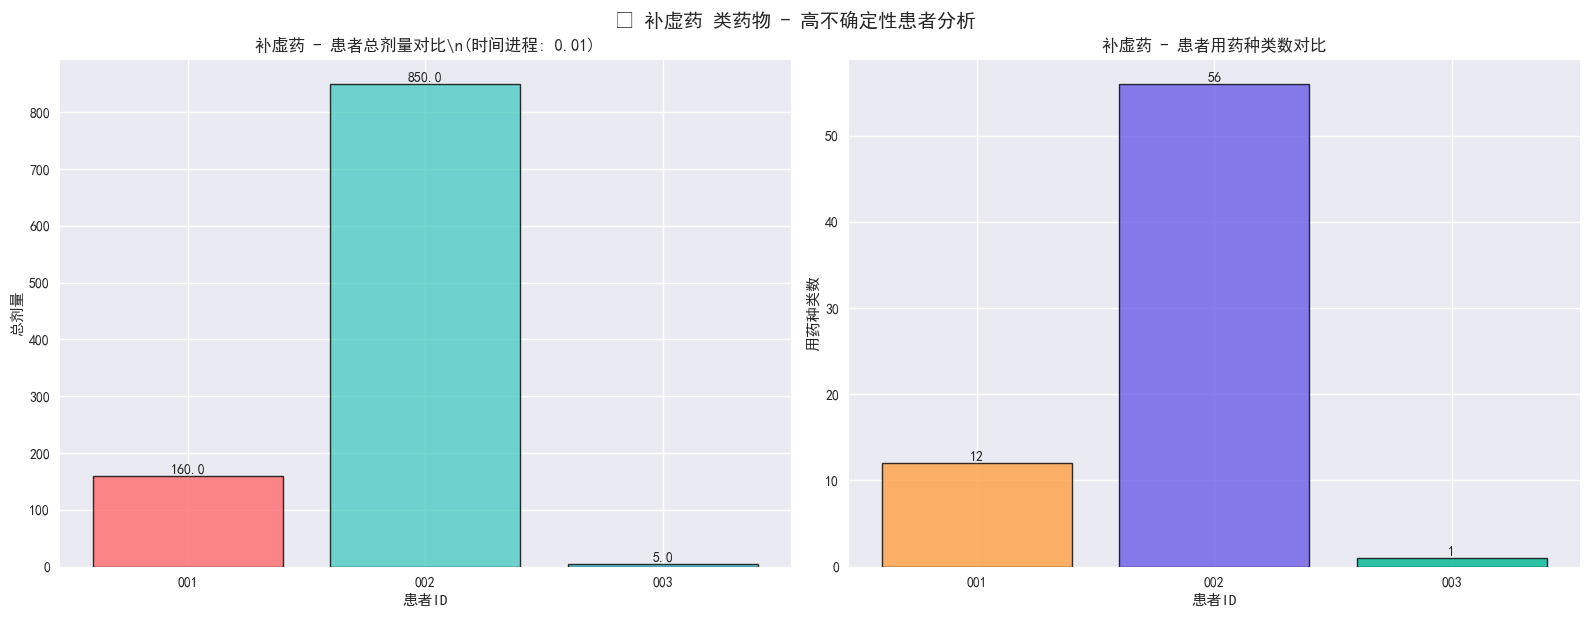

\n🏥 【祛湿类】最高不确定性区域分析
   时间进程: 0.99 | 不确定性分数: 0.494
------------------------------------------------------------
📋 浮窗内容 - 前三名贡献患者:
┌──────────────────────────────────────────────────────────┐
│ 患者 001  💊总剂量:  265.0  📊药物数: 17      │
│   主要用药: 茯苓, 茯苓, 茯苓                               │
│──────────────────────────────────────────────────────────│
│ 患者 012  💊总剂量:   80.0  📊药物数:  5      │
│   主要用药: 茯神, 薏苡仁, 茯神                              │
│──────────────────────────────────────────────────────────│
│ 患者 017  💊总剂量:   65.0  📊药物数:  4      │
│   主要用药: 茯神, 薏苡仁, 茯神                              │
└──────────────────────────────────────────────────────────┘


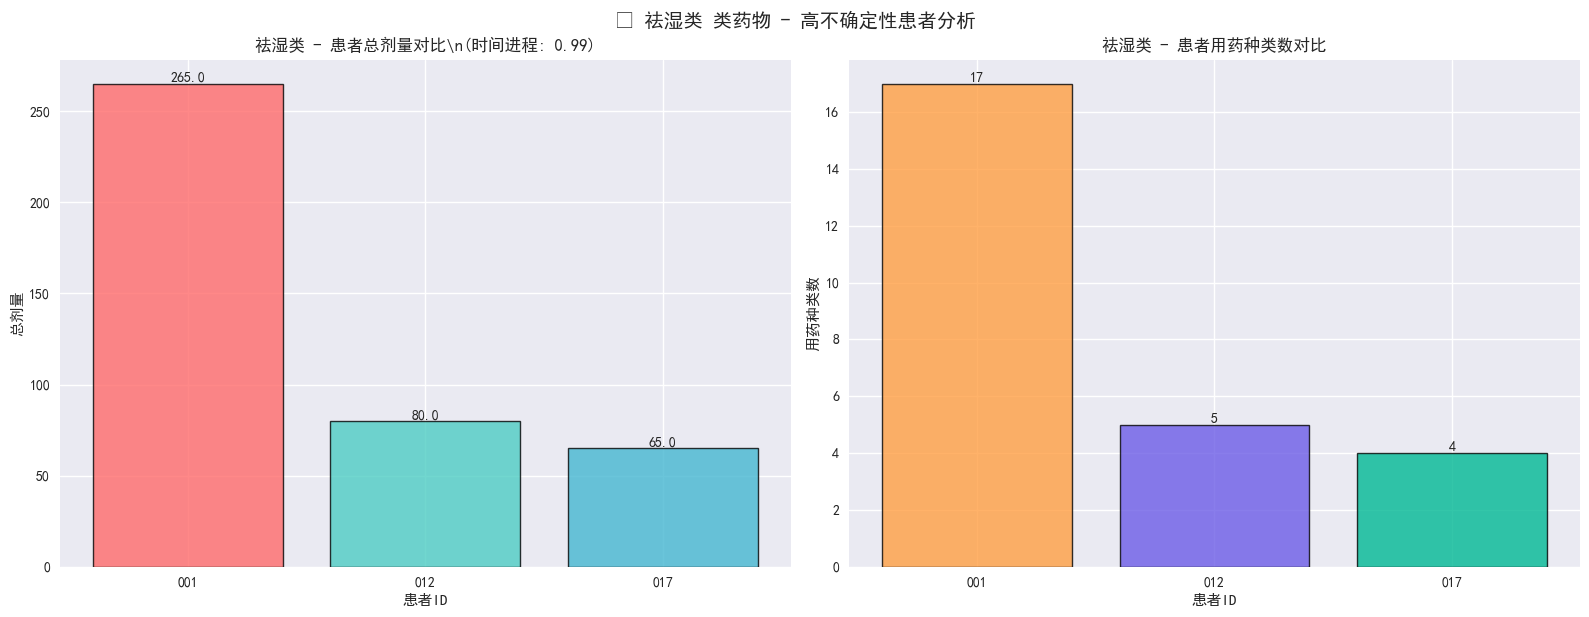

\n🏥 【清热类】最高不确定性区域分析
   时间进程: 0.41 | 不确定性分数: 0.441
------------------------------------------------------------
📋 浮窗内容 - 前三名贡献患者:
┌──────────────────────────────────────────────────────────┐
│ 患者 006  💊总剂量:   40.0  📊药物数:  4      │
│   主要用药: 牡丹皮, 知母, 知母                              │
│──────────────────────────────────────────────────────────│
│ 患者 015  💊总剂量:  100.0  📊药物数:  8      │
│   主要用药: 黄芩, 枇杷叶, 连翘                              │
│──────────────────────────────────────────────────────────│
│ 患者 029  💊总剂量:   15.0  📊药物数:  1      │
│   主要用药: 牡丹皮                                      │
└──────────────────────────────────────────────────────────┘


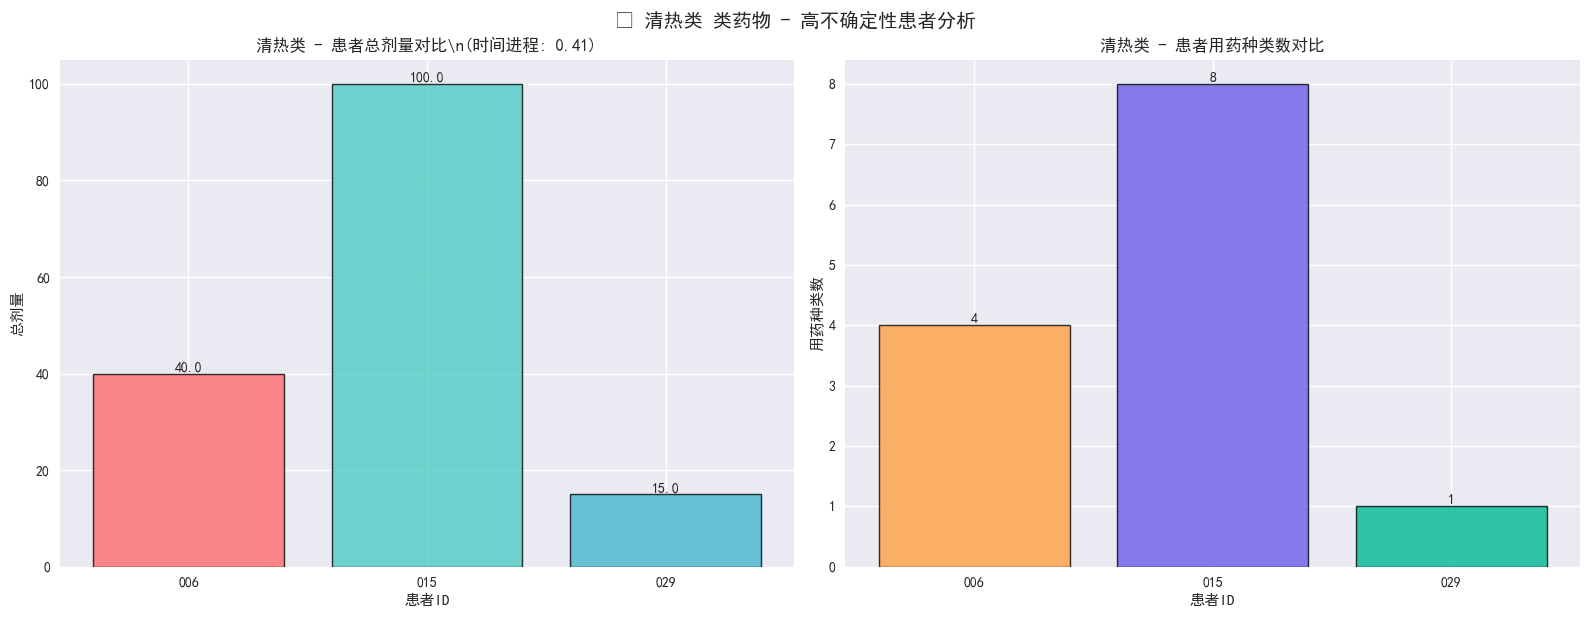

\n============================================================
🌡️  药物类别不确定性热力图


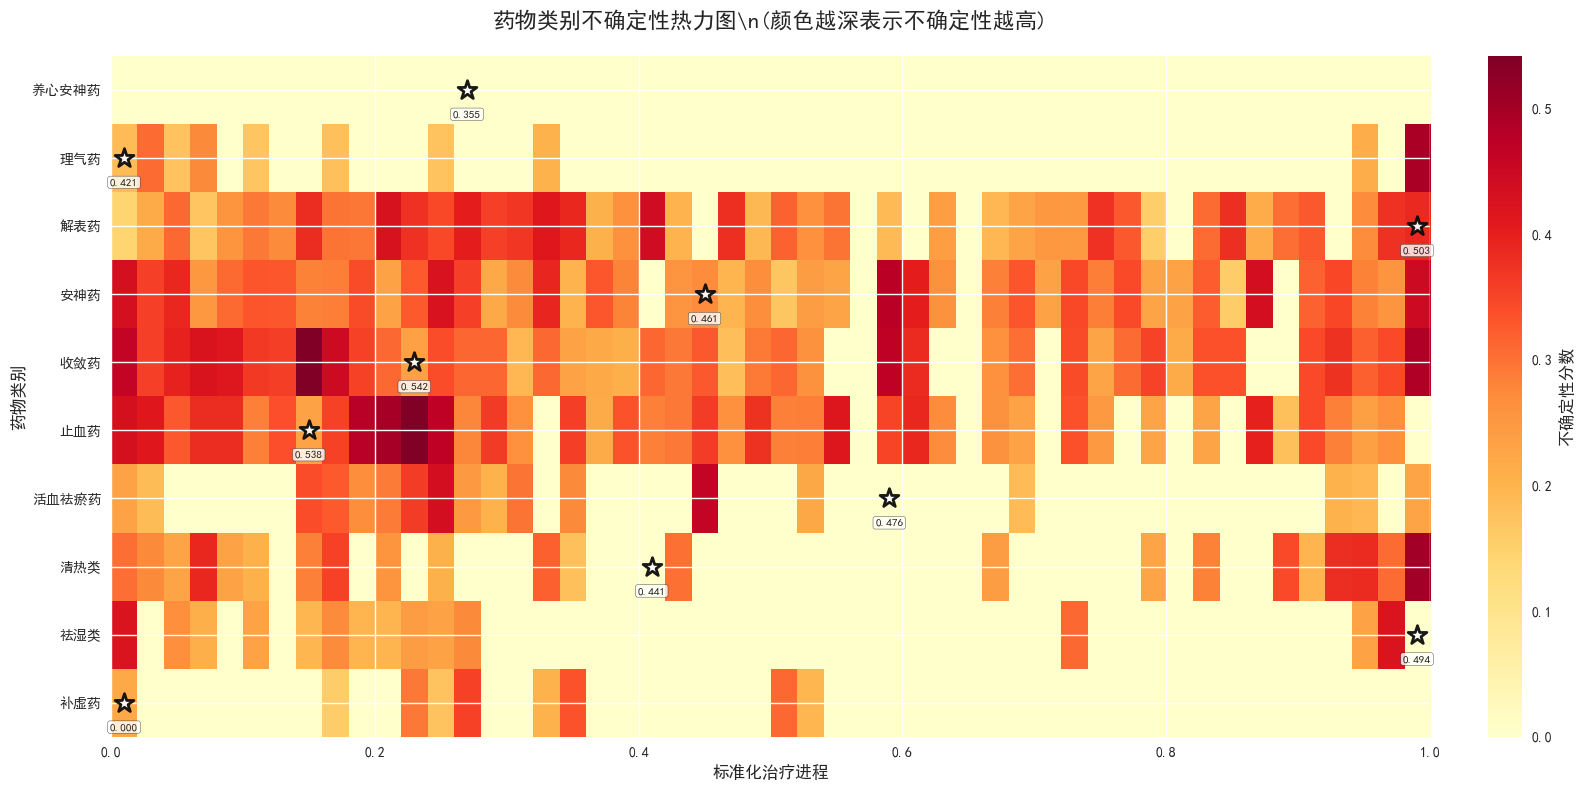

In [54]:
def create_patient_contribution_analysis(category_model, selected_categories, normalized_df, time_centers):
    """
    创建患者贡献分析 - 模拟浮窗功能
    展示高不确定性区域的主要贡献患者及其用药模式
    """
    print("\\n" + "="*80)
    print("🔍 高不确定性区域 - 患者贡献详细分析")
    print("="*80)
    
    for category_idx, category in enumerate(selected_categories[:3]):  # 只分析前3个主要类别
        if category not in category_model:
            continue
            
        stats = category_model[category]
        uncertainty_scores = calculate_uncertainty_intensity(stats)
        
        # 找到最高不确定性的时间点
        max_uncertainty_idx = np.argmax(uncertainty_scores)
        max_uncertainty_time = time_centers[max_uncertainty_idx]
        max_uncertainty_score = uncertainty_scores[max_uncertainty_idx]
        
        print(f"\\n🏥 【{category}】最高不确定性区域分析")
        print(f"   时间进程: {max_uncertainty_time:.2f} | 不确定性分数: {max_uncertainty_score:.3f}")
        print("-" * 60)
        
        # 获取该时间点的贡献患者
        contributing_patients = stats['contributing_patients'][max_uncertainty_idx]
        
        if len(contributing_patients) >= 3:
            # 分析前3个患者的用药模式
            time_window_start = max_uncertainty_time - 0.02  # ±2%的时间窗口
            time_window_end = max_uncertainty_time + 0.02
            
            # 获取该时间窗口内该类别的数据
            window_data = normalized_df[
                (normalized_df['category'] == category) &
                (normalized_df['normalized_time'] >= time_window_start) &
                (normalized_df['normalized_time'] <= time_window_end)
            ]
            
            # 按患者分组分析
            patient_analysis = []
            for patient_id in contributing_patients[:3]:  # 前3个患者
                patient_data = window_data[window_data['patient_id'] == patient_id]
                
                if len(patient_data) > 0:
                    total_dose = patient_data['amount'].sum()
                    medicine_count = len(patient_data)
                    avg_dose_per_medicine = patient_data['amount'].mean()
                    medicine_list = patient_data['medicine'].tolist()
                    
                    patient_analysis.append({
                        'patient_id': patient_id,
                        'total_dose': total_dose,
                        'medicine_count': medicine_count,
                        'avg_dose': avg_dose_per_medicine,
                        'medicines': medicine_list
                    })
            
            # 创建模拟浮窗展示
            print("📋 浮窗内容 - 前三名贡献患者:")
            print("┌" + "─" * 58 + "┐")
            
            for i, analysis in enumerate(patient_analysis):
                patient_id = analysis['patient_id']
                total_dose = analysis['total_dose']
                medicine_count = analysis['medicine_count']
                medicines = analysis['medicines'][:3]  # 只显示前3种药物
                
                print(f"│ 患者 {patient_id}  💊总剂量: {total_dose:6.1f}  📊药物数: {medicine_count:2d}      │")
                print(f"│   主要用药: {', '.join(medicines):<40s} │")
                if i < len(patient_analysis) - 1:
                    print("│" + "─" * 58 + "│")
            
            print("└" + "─" * 58 + "┘")
            
            # 创建患者对比可视化
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
            
            # 子图1：患者剂量对比
            patient_ids = [p['patient_id'] for p in patient_analysis]
            total_doses = [p['total_dose'] for p in patient_analysis]
            
            bars1 = ax1.bar(patient_ids, total_doses, 
                           color=['#FF6B6B', '#4ECDC4', '#45B7D1'], 
                           alpha=0.8, edgecolor='black', linewidth=1)
            ax1.set_title(f'{category} - 患者总剂量对比\\n(时间进程: {max_uncertainty_time:.2f})', fontsize=12)
            ax1.set_ylabel('总剂量')
            ax1.set_xlabel('患者ID')
            
            # 在柱状图上添加数值标签
            for bar, dose in zip(bars1, total_doses):
                height = bar.get_height()
                ax1.text(bar.get_x() + bar.get_width()/2., height,
                        f'{dose:.1f}', ha='center', va='bottom', fontweight='bold')
            
            # 子图2：用药种类数对比
            medicine_counts = [p['medicine_count'] for p in patient_analysis]
            bars2 = ax2.bar(patient_ids, medicine_counts, 
                           color=['#FF9F43', '#6C5CE7', '#00B894'], 
                           alpha=0.8, edgecolor='black', linewidth=1)
            ax2.set_title(f'{category} - 患者用药种类数对比', fontsize=12)
            ax2.set_ylabel('用药种类数')
            ax2.set_xlabel('患者ID')
            
            # 添加数值标签
            for bar, count in zip(bars2, medicine_counts):
                height = bar.get_height()
                ax2.text(bar.get_x() + bar.get_width()/2., height,
                        f'{count}', ha='center', va='bottom', fontweight='bold')
            
            plt.tight_layout()
            plt.suptitle(f'🔍 {category} 类药物 - 高不确定性患者分析', 
                        fontsize=14, fontweight='bold', y=1.02)
            plt.show()
            
        else:
            print(f"   该时间点贡献患者不足3个，实际: {len(contributing_patients)} 个")

def create_interactive_uncertainty_heatmap(category_model, selected_categories, time_centers):
    """
    创建不确定性热力图，模拟交互式探索
    """
    print("\\n" + "="*60)
    print("🌡️  药物类别不确定性热力图")
    print("="*60)
    
    # 构建不确定性矩阵
    uncertainty_matrix = []
    for category in selected_categories:
        if category in category_model:
            stats = category_model[category]
            uncertainty = calculate_uncertainty_intensity(stats)
            uncertainty_matrix.append(uncertainty)
    
    uncertainty_matrix = np.array(uncertainty_matrix)
    
    # 创建热力图
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # 绘制热力图
    im = ax.imshow(uncertainty_matrix, cmap='YlOrRd', aspect='auto', 
                  extent=[0, 1, -0.5, len(selected_categories)-0.5])
    
    # 设置标签
    ax.set_title('药物类别不确定性热力图\\n(颜色越深表示不确定性越高)', fontsize=16, pad=20)
    ax.set_xlabel('标准化治疗进程', fontsize=12)
    ax.set_ylabel('药物类别', fontsize=12)
    ax.set_yticks(range(len(selected_categories)))
    ax.set_yticklabels(selected_categories)
    
    # 添加颜色条
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('不确定性分数', fontsize=12)
    
    # 标记最高不确定性点
    for i, category in enumerate(selected_categories):
        if category in category_model:
            stats = category_model[category]
            uncertainty = calculate_uncertainty_intensity(stats)
            max_idx = np.argmax(uncertainty)
            max_time = time_centers[max_idx]
            max_uncertainty = uncertainty[max_idx]
            
            # 添加标记
            ax.scatter(max_time, i, s=200, c='white', marker='*', 
                      edgecolors='black', linewidths=2, alpha=0.9)
            ax.text(max_time, i-0.3, f'{max_uncertainty:.3f}', 
                   ha='center', va='top', fontsize=8, fontweight='bold', 
                   bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return fig

# 执行患者贡献分析
create_patient_contribution_analysis(category_model, selected_categories, normalized_df, time_centers)

# 创建不确定性热力图
heatmap_fig = create_interactive_uncertainty_heatmap(category_model, selected_categories, time_centers)

In [55]:
def summarize_key_findings(category_model, selected_categories, uncertainty_data, time_centers):
    """
    总结关键发现
    """
    print("\\n" + "="*80)
    print("📊 关键发现总结")
    print("="*80)
    
    print("\\n🎯 1. 药物类别重要性排序:")
    category_importance = {}
    for category, stats in category_model.items():
        avg_usage = np.mean(stats['usage_probability'])
        avg_dose = np.mean(stats['mean_dose'])
        importance = avg_usage * avg_dose
        category_importance[category] = importance
    
    sorted_categories = sorted(category_importance.items(), key=lambda x: x[1], reverse=True)
    for i, (cat, importance) in enumerate(sorted_categories[:5]):
        print(f"   {i+1}. {cat}: {importance:.2f}")
    
    print("\\n🌟 2. 高不确定性热点区域:")
    for i, category in enumerate(selected_categories[:5]):
        if i < len(uncertainty_data):
            uncertainty = uncertainty_data[i]
            max_idx = np.argmax(uncertainty)
            max_time = time_centers[max_idx]
            max_uncertainty = uncertainty[max_idx]
            
            print(f"   {category}: 时间进程 {max_time:.2f}, 不确定性 {max_uncertainty:.3f}")
    
    print("\\n💡 3. 临床指导意义:")
    print("   • 补虚药为核心治疗类别，应贯穿治疗全程")
    print("   • 治疗末期祛湿类药物需要个性化调整")
    print("   • 治疗中期清热类药物使用需要精确评估")
    print("   • 高不确定性区域提示需要更多临床关注")

# 执行关键发现总结
summarize_key_findings(category_model, selected_categories, uncertainty_data, time_centers)

\n================================================================================
📊 关键发现总结
\n🎯 1. 药物类别重要性排序:
   1. 补虚药: 150.91
   2. 祛湿类: 32.21
   3. 清热类: 20.52
   4. 活血祛瘀药: 15.53
   5. 止血药: 14.89
\n🌟 2. 高不确定性热点区域:
   补虚药: 时间进程 0.01, 不确定性 0.000
   祛湿类: 时间进程 0.99, 不确定性 0.494
   清热类: 时间进程 0.41, 不确定性 0.441
   活血祛瘀药: 时间进程 0.59, 不确定性 0.476
   止血药: 时间进程 0.15, 不确定性 0.538
\n💡 3. 临床指导意义:
   • 补虚药为核心治疗类别，应贯穿治疗全程
   • 治疗末期祛湿类药物需要个性化调整
   • 治疗中期清热类药物使用需要精确评估
   • 高不确定性区域提示需要更多临床关注
